In [243]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

%matplotlib inline

### Data preparation
- Keep only the columns above
- Lowercase the column names and replace spaces with underscores
- Fill the missing values with 0
- Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average
- Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [263]:
data = pd.read_csv('data.csv')
features = ['Make',
            'Model',
            'Year',
            'Engine HP',
            'Engine Cylinders',
            'Transmission Type',
            'Vehicle Style',
            'highway MPG',
            'city mpg',
            'MSRP']
data = data[features]

data.columns = data.columns.str.replace(' ', '_').str.lower()
data.engine_hp = data.engine_hp.fillna(0)
data.engine_cylinders = data.engine_cylinders.fillna(0)

data.rename(columns={"msrp": "price"}, inplace=True)
data["above_average"] = data.price.apply(lambda x : 1 if x >= data.price.mean() else 0)

In [264]:
data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [265]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['price']
del df_val['price']
del df_test['price']

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.
Let's do that
- For each numerical variable, use it as score and compute AUC with the above_average variable
- Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
- engine_hp
- engine_cylinders
- highway_mpg
- city_mpg

In [266]:
categorical = df_train.select_dtypes('object').columns.tolist()
numerical = df_train.select_dtypes('number').columns.tolist()

In [267]:
scores = []
for col in numerical:
    if col in ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']:
        score = roc_auc_score(y_train, df_train[col])
        scores.append((col, score.round(3)))

In [268]:
pd.DataFrame(scores, columns=['columns', 'scores']).sort_values(by='scores', ascending=False)

,columns,scores
0,engine_hp,0.917
1,engine_cylinders,0.766
2,highway_mpg,0.367
3,city_mpg,0.327


### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
- LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)
- 0.678
- 0.779
- 0.878
- 0.979

In [269]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [270]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred).round(3)

0.979

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?
- 0.28
- 0.48
- 0.68
- 0.88

In [271]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = y_val == 1
    actual_negative = y_val == 0
    
    predict_positive = y_pred >= t
    predict_negative = y_pred < t
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [272]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,334,10,1395
20,0.2,623,201,31,1528
30,0.3,606,143,48,1586
40,0.4,590,106,64,1623
50,0.5,569,73,85,1656
60,0.6,550,51,104,1678
70,0.7,506,30,148,1699
80,0.8,464,21,190,1708
90,0.9,376,3,278,1726


In [273]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores [::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,654,1729,0,0,0.274444,1.000000
10,0.1,644,334,10,1395,0.658487,0.984709
20,0.2,623,201,31,1528,0.756068,0.952599
30,0.3,606,143,48,1586,0.809079,0.926606
40,0.4,590,106,64,1623,0.847701,0.902141
50,0.5,569,73,85,1656,0.886293,0.870031
60,0.6,550,51,104,1678,0.915141,0.840979
70,0.7,506,30,148,1699,0.944030,0.773700
80,0.8,464,21,190,1708,0.956701,0.709480
90,0.9,376,3,278,1726,0.992084,0.574924


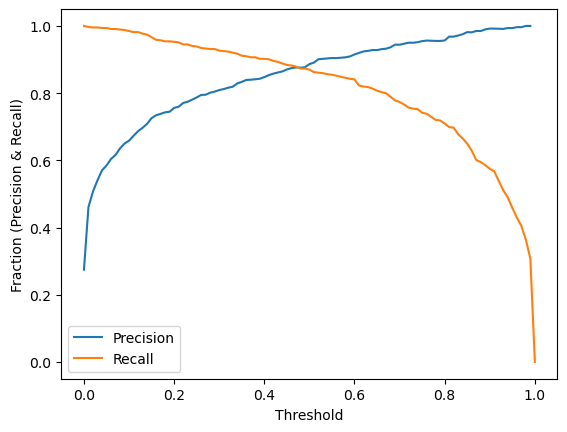

In [274]:
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Fraction (Precision & Recall)')
plt.legend()
plt.show()

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
    
$$\frac{2*Precision * Recall}{Precision+Recall}$$

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?
- 0.12
- 0.32
- 0.52
- 0.72

In [275]:
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)
df_scores.head()

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.00,654,1729,0,0,0.274444,1.000000,0.430688
1,0.01,652,762,2,967,0.461103,0.996942,0.630561
2,0.02,651,633,3,1096,0.507009,0.995413,0.671827
3,0.03,651,553,3,1176,0.540698,0.995413,0.700753
4,0.04,650,490,4,1239,0.570175,0.993884,0.724638


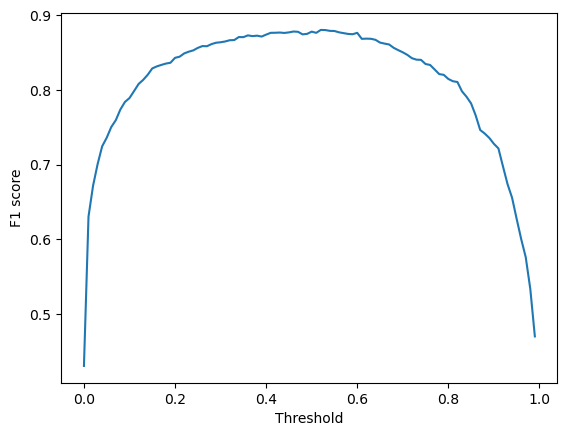

In [276]:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

plt.show()

### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

##### KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?
- 0.003
- 0.030
- 0.090
- 0.140

In [280]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    del df_train['above_average']
    del df_val['above_average']

    del df_train['price']
    del df_val['price']


    train_dict = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [281]:
np.std(scores)

0.0012316422388244349

### Question 6: Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C
- Iterate over the following C values: [0.01, 0.1, 0.5, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?
- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [282]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.002
C= 0.1, 0.972 +- 0.002
C= 0.5, 0.977 +- 0.001
C=  10, 0.984 +- 0.003
